# Imports & Load data



In [1]:
import os
from os.path import join as pjoin

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
import xgboost as xgb

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA


In [3]:
# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.preprocessing import Binarizer, scale,normalize

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,8)

In [59]:
train = pd.read_csv('../data/train.csv')

In [60]:
test = pd.read_csv('../data/test.csv')

# Helper functions

In [61]:
def split(x,n=None):
    if n==None:
        n=int(len(x)*.7)
    
    return x[:n],x[n:]

# Provide a place holder for train
def split_data(df):
    y = df['TARGET'].copy()
    x = df.drop('TARGET',axis=1)
    global X_train,X_valid,y_train,y_valid
    
    X_train ,X_valid = split(x)
    y_train ,y_valid = split(y)

In [62]:

def eval(clf):
    train_pred = clf.predict_proba(X_train)[:,1]
    valid_pred = clf.predict_proba(X_valid)[:,1]
    if train_pred.sum()==0:
        print("All prediciton on train is 0")
        
    if valid_pred.sum()==0:
        print("All prediciton on valid is 0")
    print('ROC on training set : ',roc_auc_score(y_train,train_pred))
    print('ROC on valid set : ',roc_auc_score(y_valid,valid_pred))
    
    

In [63]:
def plot_fi(clf,n_top=30):
    fi = pd.DataFrame({'cols':X_train.columns,'fi':clf.feature_importances_}).sort_values('fi',ascending=False)
    fi.iloc[:n_top].plot(x='cols',y='fi',kind='barh')
    return list(fi.cols.values)
    

In [64]:
def base_model():
    clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
    clf.fit(X_train,y_train)
    eval(clf)

# Data walkthrough

In [65]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [66]:
train.shape

(76020, 371)

In [67]:
train.columns

Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)

In [68]:
train.isnull().sum()

ID                               0
var3                             0
var15                            0
imp_ent_var16_ult1               0
imp_op_var39_comer_ult1          0
imp_op_var39_comer_ult3          0
imp_op_var40_comer_ult1          0
imp_op_var40_comer_ult3          0
imp_op_var40_efect_ult1          0
imp_op_var40_efect_ult3          0
imp_op_var40_ult1                0
imp_op_var41_comer_ult1          0
imp_op_var41_comer_ult3          0
imp_op_var41_efect_ult1          0
imp_op_var41_efect_ult3          0
imp_op_var41_ult1                0
imp_op_var39_efect_ult1          0
imp_op_var39_efect_ult3          0
imp_op_var39_ult1                0
imp_sal_var16_ult1               0
ind_var1_0                       0
ind_var1                         0
ind_var2_0                       0
ind_var2                         0
ind_var5_0                       0
ind_var5                         0
ind_var6_0                       0
ind_var6                         0
ind_var8_0          

# Feature engineering

## Drop skewed columns

In [69]:
skew_cols = []
for col in train.columns:
    train_cnt = train[col].value_counts().sort_values(ascending=False)/len(train)
    if train_cnt.values[0]>0.999:
        skew_cols.append(col)
        
train.drop(skew_cols,axis=1,inplace=True)        
test.drop(skew_cols,axis=1,inplace=True)
print(f'{len(skew_cols)} columns with skewed value')

146 columns with skewed value


## Drop duplicate columns

In [70]:
dup_cols = []
for col_1 in train.columns:
    v = train[col_1].values
    for col_2 in train.columns:
        if col_1 != col_2:
            if np.array_equal(train[col_1],train[col_2]):
                dup_cols.append(col_2)

train.drop(dup_cols,axis=1,inplace=True)
test.drop(dup_cols,axis=1,inplace=True)

print(f'{len(dup_cols)} columns with duplicate value')

20 columns with duplicate value


## Var3 bug

In [71]:
train['var3'].replace(-999999,0, inplace=True)
test['var3'].replace(-999999,0, inplace=True)

## ID

In [72]:
train.drop('ID',axis=1,inplace=True)
test_id = test.ID
test.drop('ID',axis=1,inplace=True)

## Drop duplicates

In [74]:
print('before :{},{}'.format(train.shape,test.shape))
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
print('after :{},{}'.format(train.shape,test.shape))

before :(76020, 204),(75818, 203)
after :(71212, 204),(70895, 203)


## Adding PCA

In [75]:
pca = PCA(n_components=3)
x_train_projected = pca.fit_transform(normalize(train.drop('TARGET',axis=1), axis=0))
x_test_projected = pca.transform(normalize(test, axis=0))
print(pca.explained_variance_ratio_)
train.insert(1, 'PCA1', x_train_projected[:, 0])
train.insert(1, 'PCA2', x_train_projected[:, 1])
train.insert(1, 'PCA3', x_train_projected[:, 2])

test.insert(1, 'PCA1', x_test_projected[:, 0])
test.insert(1, 'PCA2', x_test_projected[:, 1])
test.insert(1, 'PCA3', x_test_projected[:, 2])


[0.11053277 0.08410346 0.06105414]


## Feature selection
SelectKBest will return top k features

SelectPercentile will return a sub set of your features

### Filter method

In [22]:
ps = [40,45,50,55,60,65,70,75,80,85,90,95]

In [23]:
for p in ps :
    split_data(train)
    # Preprocessing
    X = pd.concat([X_train,X_valid])
    X_bin = Binarizer().fit_transform(scale(X))
    y_ = pd.concat([y_train,y_valid])

    # get the columns
    selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_)
    selected_cols = list(X_train.columns[selectChi2.get_support()].values) + ["TARGET"]
    
    # test
    split_data(train[selected_cols])
    clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
    clf.fit(X_train,y_train)
    print('-'*100)
    print(p)
    print(len(selected_cols))
    eval(clf)
    


----------------------------------------------------------------------------------------------------
40
83
ROC on training set :  0.877417848981377
ROC on valid set :  0.8249092034513875
----------------------------------------------------------------------------------------------------
45
94
ROC on training set :  0.8787207717833256
ROC on valid set :  0.8252115498839137
----------------------------------------------------------------------------------------------------
50
104
ROC on training set :  0.8826926495992125
ROC on valid set :  0.8263338738906487
----------------------------------------------------------------------------------------------------
55
114
ROC on training set :  0.875434444998163
ROC on valid set :  0.8201274483553658
----------------------------------------------------------------------------------------------------
60
124
ROC on training set :  0.8799474662864276
ROC on valid set :  0.8215660958217831
-----------------------------------------------------------

Test results

In [76]:
p = 60

split_data(train)
# Preprocessing
X = pd.concat([X_train,X_valid])
X_bin = Binarizer().fit_transform(scale(X))
y_ = pd.concat([y_train,y_valid])

# get the columns
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_)
selected_cols = list(X_train.columns[selectChi2.get_support()].values)
selected_cols

['var3',
 'PCA3',
 'PCA2',
 'PCA1',
 'var15',
 'imp_op_var41_efect_ult1',
 'imp_op_var41_efect_ult3',
 'imp_op_var39_efect_ult1',
 'imp_op_var39_efect_ult3',
 'imp_sal_var16_ult1',
 'ind_var1',
 'ind_var5',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13_largo',
 'ind_var13',
 'ind_var14_0',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_cte',
 'ind_var30',
 'ind_var31_0',
 'ind_var39_0',
 'ind_var41_0',
 'num_var1',
 'num_var4',
 'num_var5',
 'num_var8_0',
 'num_var8',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14_0',
 'num_var20_0',
 'num_var20',
 'num_var24_0',
 'num_var24',
 'num_var30_0',
 'num_var30',
 'num_var31_0',
 'num_var35',
 'num_var39_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'saldo_var1',
 'saldo_v

In [77]:
train = train[selected_cols + ['TARGET']]
test = test[selected_cols]

### Wrapper methods



In [25]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

ROC on training set :  0.7971356804515795
ROC on valid set :  0.7524624226061213


Tested with step = 1/2 . step 2 return better score

In [27]:
# step is how many feature to remove at a time
dtree_rfe = RFECV(clf, step=2,scoring = 'roc_auc', cv = 5) 
dtree_rfe.fit(X_train,y_train)

In [97]:
rfecv_step_2 = list(rfecv_step_2) + ['TARGET']

In [112]:
split_data(train[rfecv_step_2])

In [113]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

/Users/macbook/miniconda3/envs/dev/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC on training set :  0.8159160278600914
ROC on valid set :  0.7446744278861178


# Modeling

## RandomForest

Note: for sparse data include class_weight will handle it

In [26]:
split_data(train)

Tried with these params : n_estimators=30,min_samples_leaf=10,max_features='log2',n_jobs=-1

The model predict all samples are 0 => extremely overfit

In [27]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

ROC on training set :  0.8799474662864276
ROC on valid set :  0.8215660958217831


In [28]:
X_train.columns

Index(['var3', 'PCA3', 'PCA2', 'PCA1', 'var15', 'imp_op_var41_efect_ult1',
       'imp_op_var41_efect_ult3', 'imp_op_var39_efect_ult1',
       'imp_op_var39_efect_ult3', 'imp_sal_var16_ult1',
       ...
       'saldo_medio_var12_ult3', 'saldo_medio_var13_corto_hace2',
       'saldo_medio_var13_corto_hace3', 'saldo_medio_var13_corto_ult1',
       'saldo_medio_var13_corto_ult3', 'saldo_medio_var13_largo_hace2',
       'saldo_medio_var13_largo_hace3', 'saldo_medio_var13_largo_ult1',
       'saldo_medio_var13_largo_ult3', 'var38'],
      dtype='object', length=123)

### Using feature important

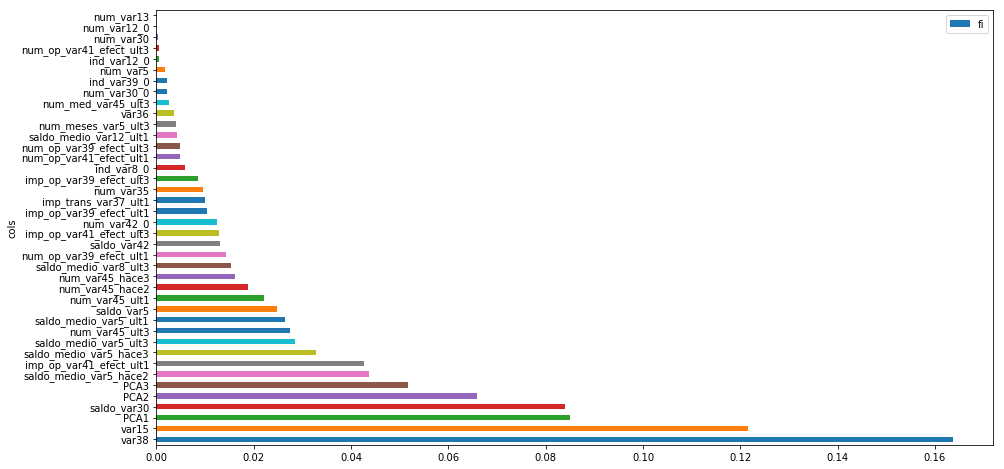

In [41]:
imp_cols = plot_fi(clf,40)

In [53]:
split_data(train[imp_cols[:30] +['TARGET']])

In [54]:
clf = RFC(criterion='gini', class_weight='balanced', max_depth=10,random_state=1)
clf.fit(X_train,y_train)
eval(clf)

ROC on training set :  0.8923764279311777
ROC on valid set :  0.8304002505761012


look better

In [52]:
train = train[imp_cols[:30] +['TARGET']]
test = [imp_cols[:30]]

## XGBoost
Let's try with xgboost

In [45]:
split_data(train)

In [46]:
# classifier
clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, 
                        learning_rate=0.03, nthread=4, subsample=0.95, 
                        colsample_bytree=0.85, seed=4242)


In [47]:
clf.fit(X_train,y_train,early_stopping_rounds=20, eval_metric="auc",eval_set=[(X_valid,y_valid)])

[0]	validation_0-auc:0.776881
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.816757
[2]	validation_0-auc:0.822706
[3]	validation_0-auc:0.826065
[4]	validation_0-auc:0.827583
[5]	validation_0-auc:0.830845
[6]	validation_0-auc:0.830833
[7]	validation_0-auc:0.831386
[8]	validation_0-auc:0.831684
[9]	validation_0-auc:0.832652
[10]	validation_0-auc:0.833482
[11]	validation_0-auc:0.833582
[12]	validation_0-auc:0.833487
[13]	validation_0-auc:0.832695
[14]	validation_0-auc:0.833088
[15]	validation_0-auc:0.831674
[16]	validation_0-auc:0.832919
[17]	validation_0-auc:0.833671
[18]	validation_0-auc:0.833939
[19]	validation_0-auc:0.834503
[20]	validation_0-auc:0.835117
[21]	validation_0-auc:0.835612
[22]	validation_0-auc:0.835764
[23]	validation_0-auc:0.836203
[24]	validation_0-auc:0.836845
[25]	validation_0-auc:0.836125
[26]	validation_0-auc:0.836628
[27]	validation_0-auc:0.835787
[28]	validation_0-auc:0.83574
[29]	validation_0-auc:0.835918
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=350, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=4242, silent=True, subsample=0.95)

In [48]:
eval(clf)

ROC on training set :  0.8765825402044052
ROC on valid set :  0.8448581981278482


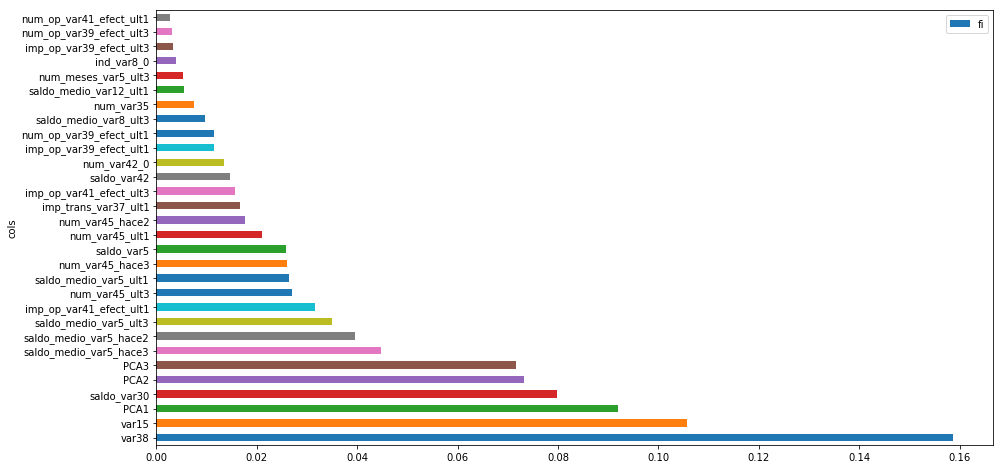

In [49]:
imp_cols = plot_fi(clf)

## LightGBM

# Stacking